# Game Matrix Solver Accuracy Analysis
This tutorial compares the accuracies of serveral Nash solvers for game matrix. 

In [9]:
import numpy as np
# ! pip install pandas
import pandas as pd
GameMatrix = np.array([[2,1], [1,1]])
# GameMatrix = np.array([[0,2,-1], [-1,0,1], [1,-1,0]])

NumAgents = 2

print('Game matrix: ')
pd.DataFrame(GameMatrix)


Game matrix: 


,0,1
0,2,1
1,1,1


In [10]:
import sys
sys.path.append("../..")  # get mars folder
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumMWUSolver

ne_ecos, ne_value_ecos = NashEquilibriumECOSSolver(GameMatrix)
ne_mwu, ne_value_mwu = NashEquilibriumMWUSolver(GameMatrix, Itr=10)
print(f"Nash strategies solved by two solvers: \nECOS {ne_ecos}, \nMWU {ne_mwu}")


Nash strategies solved by two solvers: 
ECOS (array([0.5157873, 0.4842127]), array([3.28893813e-11, 1.00000000e+00])), 
MWU [[0.62506776 0.37493217]
 [0.32717959 0.67282028]]


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


In [3]:
import numpy as np

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def random_game_matrix(dim, number=1):
    """ retrun dim*dim uniform payoff matrix for max player."""    
    rand_matrices = np.random.uniform(-1,1, size=(number, dim, dim))
    print(rand_matrices.shape)
    return rand_matrices


def compare_solvers(mwu_itr=10):
    number_tests = 1000
    dim = 3 # number of actions per player

    test_matrices = random_game_matrix(dim, number_tests)
    avg_kl = []
    for matrix in test_matrices:
        ne_ecos, ne_value_ecos = NashEquilibriumECOSSolver(matrix)
        ne_mwu, ne_value_mwu = NashEquilibriumMWUSolver(matrix, Itr=mwu_itr)
        players_kl = []
        for ecos_pi, mwu_pi in zip(ne_ecos, ne_mwu):
            players_kl.append(kl(ecos_pi, mwu_pi))
        avg_kl.append(np.mean(players_kl))  # average over two players

    print(f'avg. kl: {np.mean(avg_kl)}')
    return np.mean(avg_kl)



## Solving Iteration

(1000, 3, 3)


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


avg. kl: 0.3019965753128616
(1000, 3, 3)
avg. kl: 0.24413487095101347
(1000, 3, 3)
avg. kl: 0.20543419958894316
(1000, 3, 3)
avg. kl: 0.1912415608699278
(1000, 3, 3)
avg. kl: 0.17293169280343176
(1000, 3, 3)
avg. kl: 0.1611522225412801
(1000, 3, 3)
avg. kl: 0.15708570694260807
(1000, 3, 3)
avg. kl: 0.15661327749750584
(1000, 3, 3)
avg. kl: 0.14222384674579025


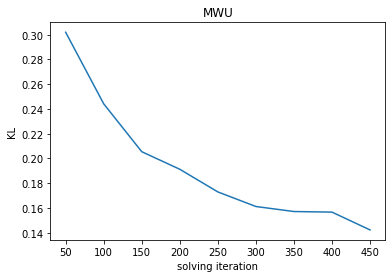

In [30]:
# MWU solver with different iterations
# evaluated by KL divergence of nash strategies by MWU and ECOS (as oracle)
import matplotlib.pyplot as plt

kl_list = []
itr_list = []
for i in range(1, 10):
    itr = i*50
    itr_list.append(itr)
    kl_list.append(compare_solvers(itr))

# for itr in [500, 1000]:
#     itr_list.append(itr)
#     kl_list.append(compare_solvers(itr))
plt.title('MWU')
plt.xlabel('solving iteration')
plt.ylabel('KL')
plt.plot(itr_list,kl_list)
plt.savefig('mwu_different_itr.png')


## Learning Rate

Here the MWU with fixed learning rate and adaptive/decayed learning rate (with different decay rates) are compared.

In [11]:
import copy

def NashEquilibriumMWUSolver(A, Itr=500, verbose=False, adaptive_lr_rate=-0.5):
    """ Solve Nash equilibrium with multiplicative weights udpate."""
    # discount = 0.9
    EPS = 1e-7 # prevent numerical problem
    row_action_num = A.shape[0]
    col_action_num = A.shape[1]
    learning_rate = np.sqrt(np.log(row_action_num)/Itr)  # sqrt(log |A| / T)

    row_policy = np.ones(row_action_num)/row_action_num
    col_policy = np.ones(col_action_num)/col_action_num
    policies = np.array([row_policy, col_policy])
    final_policy = copy.deepcopy(policies)

    for i in range(Itr):
        if adaptive_lr_rate and (i+1) % 20 == 0:
            learning_rate = np.power(i, adaptive_lr_rate)
        policies_ = copy.deepcopy(policies)  # track old value before update (update is inplace)
        # for row player, maximizer
        payoff_vec = policies_[1] @ A.T
        policies[0] = policies[0] * np.exp(learning_rate*payoff_vec)

        # for col player, minimizer
        payoff_vec = policies_[0] @ A
        policies[1] = policies[1] * np.exp(-learning_rate*payoff_vec)

        # above is unnormalized, normalize it to be distribution
        policies = policies/np.expand_dims(EPS+np.sum(policies, axis=-1), -1)

        # MWU is average-iterate coverging, so accumulate polices
        final_policy += policies

    final_policy = final_policy / (Itr+1)

    if verbose:
        print(f'For row player, strategy is {final_policy[0]}')
        print(f'For column player, strategy is {final_policy[1]}')
        print(learning_rate)

    nash_value = final_policy[0] @ A @ final_policy[1].T
    return final_policy, nash_value
    
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def compare_solvers(mwu_itr=10, adapt=False, number_tests = 1000, dim = 3):

    test_matrices = random_game_matrix(dim, number_tests)
    avg_kl = []
    for matrix in test_matrices:
        ne_ecos, ne_value_ecos = NashEquilibriumECOSSolver(matrix)
        ne_mwu, ne_value_mwu = NashEquilibriumMWUSolver(matrix, Itr=mwu_itr, adaptive_lr_rate=adapt)
        players_kl = []
        for ecos_pi, mwu_pi in zip(ne_ecos, ne_mwu):
            players_kl.append(kl(ecos_pi, mwu_pi))
        avg_kl.append(np.mean(players_kl))  # average over two players

    print(f'avg. kl: {np.mean(avg_kl)}')
    return np.mean(avg_kl)

In [38]:
klv = compare_solvers(100, False)

(1000, 3, 3)
avg. kl: 0.24834930390811952


In [37]:
klv = compare_solvers(100, True)

(1000, 3, 3)
avg. kl: 0.19824396415473072


(1000, 3, 3)
avg. kl: 0.308467563444861
(1000, 3, 3)
avg. kl: 0.247183284296996
(1000, 3, 3)
avg. kl: 0.21705198095503495
(1000, 3, 3)
avg. kl: 0.20003712700077342
(1000, 3, 3)
avg. kl: 0.18332162147773481
(1000, 3, 3)
avg. kl: 0.17174390611996723
(1000, 3, 3)
avg. kl: 0.15578409318802863
(1000, 3, 3)
avg. kl: 0.15375901348015722
(1000, 3, 3)
avg. kl: 0.14222903517651445
(1000, 3, 3)
avg. kl: 0.2825250771458516
(1000, 3, 3)
avg. kl: 0.1948187600328626
(1000, 3, 3)
avg. kl: 0.1549977701452843
(1000, 3, 3)
avg. kl: 0.13185021958489063
(1000, 3, 3)
avg. kl: 0.11104208121534655
(1000, 3, 3)
avg. kl: 0.10232237388521491
(1000, 3, 3)
avg. kl: 0.09545085857460436
(1000, 3, 3)
avg. kl: 0.08919823571887629
(1000, 3, 3)
avg. kl: 0.08815992258886257
(1000, 3, 3)
avg. kl: 0.24162246509867005
(1000, 3, 3)
avg. kl: 0.15745655578462003
(1000, 3, 3)
avg. kl: 0.11313825154455048
(1000, 3, 3)
avg. kl: 0.09770014062395373
(1000, 3, 3)
avg. kl: 0.07887381441731701
(1000, 3, 3)
avg. kl: 0.07214728477205136

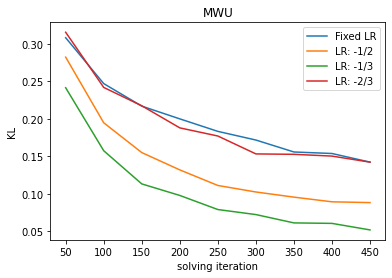

In [50]:
# MWU solver with different iterations
# evaluated by KL divergence of nash strategies by MWU and ECOS (as oracle)
import matplotlib.pyplot as plt

adaptive_lr_rates = [False, -1/2, -1/3, -2/3] # ref: Multiplicative weights update in zero-sum games
labels = ['Fixed LR', 'LR: -1/2', 'LR: -1/3', 'LR: -2/3']

for lr, label in zip(adaptive_lr_rates, labels):
    kl_list = []
    itr_list = []
    for i in range(1, 10):
        itr = i*50
        itr_list.append(itr)
        kl_list.append(compare_solvers(itr, lr))
    plt.plot(itr_list, kl_list, label=label)

plt.title('MWU')
plt.xlabel('solving iteration')
plt.ylabel('KL')
plt.legend()
plt.savefig('mwu_different_lr.png')


(100, 6, 6)
avg. kl: 0.37328325208069807
(100, 6, 6)


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


avg. kl: 0.30652973568301034
(100, 6, 6)
avg. kl: 0.2682000434742388
(100, 6, 6)
avg. kl: 0.24157935046811105
(100, 6, 6)
avg. kl: 0.21681750661162863
(100, 6, 6)
avg. kl: 0.21373501816702556
(100, 6, 6)
avg. kl: 0.20172564247162167
(100, 6, 6)
avg. kl: 0.1924211410759341
(100, 6, 6)
avg. kl: 0.17671963667800875
(100, 6, 6)
avg. kl: 0.41984730320704455
(100, 6, 6)
avg. kl: 0.26754216093072986
(100, 6, 6)
avg. kl: 0.21534717333215816
(100, 6, 6)
avg. kl: 0.19702755498884483
(100, 6, 6)
avg. kl: 0.178682009641457
(100, 6, 6)
avg. kl: 0.16549497455932904
(100, 6, 6)
avg. kl: 0.1509183370487481
(100, 6, 6)
avg. kl: 0.14807091260986283
(100, 6, 6)
avg. kl: 0.11458363354941824
(100, 6, 6)
avg. kl: 0.3166687767065094
(100, 6, 6)
avg. kl: 0.2164874575381842
(100, 6, 6)
avg. kl: 0.1557499540260849
(100, 6, 6)
avg. kl: 0.13922636057286744
(100, 6, 6)
avg. kl: 0.12763455847151295
(100, 6, 6)
avg. kl: 0.11956745581091716
(100, 6, 6)
avg. kl: 0.08925375643285434
(100, 6, 6)
avg. kl: 0.0830872820383

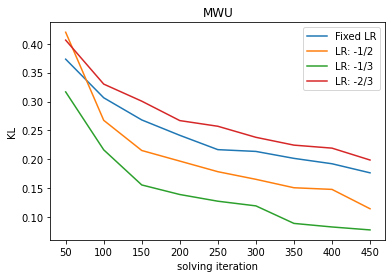

In [52]:
# MWU solver with different iterations
# evaluated by KL divergence of nash strategies by MWU and ECOS (as oracle)
import matplotlib.pyplot as plt

adaptive_lr_rates = [False, -1/2, -1/3, -2/3] # ref: Multiplicative weights update in zero-sum games
labels = ['Fixed LR', 'LR: -1/2', 'LR: -1/3', 'LR: -2/3']

for lr, label in zip(adaptive_lr_rates, labels):
    kl_list = []
    itr_list = []
    for i in range(1, 10):
        itr = i*50
        itr_list.append(itr)
        kl_list.append(compare_solvers(itr, lr, number_tests = 100, dim = 6))
    plt.plot(itr_list, kl_list, label=label)

plt.title('MWU')
plt.xlabel('solving iteration')
plt.ylabel('KL')
plt.legend()
plt.savefig('mwu_different_lr2.png')


If the learning rate is not decaying per period (20 steps in previous), but per step, will it affect the convergence performance?

In [14]:
import copy

def NashEquilibriumMWUSolver(A, Itr=500, verbose=False, adaptive_lr_rate=-0.5):
    """ Solve Nash equilibrium with multiplicative weights udpate."""
    # discount = 0.9
    EPS = 1e-7 # prevent numerical problem
    row_action_num = A.shape[0]
    col_action_num = A.shape[1]
    learning_rate = np.sqrt(np.log(row_action_num)/Itr)  # sqrt(log |A| / T)

    row_policy = np.ones(row_action_num)/row_action_num
    col_policy = np.ones(col_action_num)/col_action_num
    policies = np.array([row_policy, col_policy])
    final_policy = copy.deepcopy(policies)

    for i in range(Itr):
        if adaptive_lr_rate and i>1:  ## decay per step
            learning_rate = np.power(i, adaptive_lr_rate)
        policies_ = copy.deepcopy(policies)  # track old value before update (update is inplace)
        # for row player, maximizer
        payoff_vec = policies_[1] @ A.T
        policies[0] = policies[0] * np.exp(learning_rate*payoff_vec)

        # for col player, minimizer
        payoff_vec = policies_[0] @ A
        policies[1] = policies[1] * np.exp(-learning_rate*payoff_vec)

        # above is unnormalized, normalize it to be distribution
        policies = policies/np.expand_dims(EPS+np.sum(policies, axis=-1), -1)

        # MWU is average-iterate coverging, so accumulate polices
        final_policy += policies

    final_policy = final_policy / (Itr+1)

    if verbose:
        print(f'For row player, strategy is {final_policy[0]}')
        print(f'For column player, strategy is {final_policy[1]}')
        print(learning_rate)

    nash_value = final_policy[0] @ A @ final_policy[1].T
    return final_policy, nash_value
    
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def compare_solvers(mwu_itr=10, adapt=False, number_tests = 1000, dim = 3):

    test_matrices = random_game_matrix(dim, number_tests)
    avg_kl = []
    for matrix in test_matrices:
        ne_ecos, ne_value_ecos = NashEquilibriumECOSSolver(matrix)
        ne_mwu, ne_value_mwu = NashEquilibriumMWUSolver(matrix, Itr=mwu_itr, adaptive_lr_rate=adapt)
        players_kl = []
        for ecos_pi, mwu_pi in zip(ne_ecos, ne_mwu):
            players_kl.append(kl(ecos_pi, mwu_pi))
        avg_kl.append(np.mean(players_kl))  # average over two players

    print(f'avg. kl: {np.mean(avg_kl)}')
    return np.mean(avg_kl)

(1000, 3, 3)


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


avg. kl: 0.3094334027759404
(1000, 3, 3)
avg. kl: 0.25495117954689533
(1000, 3, 3)
avg. kl: 0.21137114458175324
(1000, 3, 3)
avg. kl: 0.19872309306027883
(1000, 3, 3)
avg. kl: 0.1778014356571053
(1000, 3, 3)
avg. kl: 0.16987073228749155
(1000, 3, 3)
avg. kl: 0.15300221170197612
(1000, 3, 3)
avg. kl: 0.14841533857523387
(1000, 3, 3)
avg. kl: 0.14377542567527213
(1000, 3, 3)
avg. kl: 0.20495829663520912
(1000, 3, 3)
avg. kl: 0.1365505859648687
(1000, 3, 3)
avg. kl: 0.11401920501412559
(1000, 3, 3)
avg. kl: 0.09905323835532873
(1000, 3, 3)
avg. kl: 0.0896422512736434
(1000, 3, 3)
avg. kl: 0.08184247473231214
(1000, 3, 3)
avg. kl: 0.08023349980126185
(1000, 3, 3)
avg. kl: 0.0708723109511629
(1000, 3, 3)
avg. kl: 0.06781695529202449
(1000, 3, 3)
avg. kl: 0.15979523535173504
(1000, 3, 3)
avg. kl: 0.1017320267640599
(1000, 3, 3)
avg. kl: 0.07742840782442943
(1000, 3, 3)
avg. kl: 0.06740770914189795
(1000, 3, 3)
avg. kl: 0.062167887759948866
(1000, 3, 3)
avg. kl: 0.05179878968473706
(1000, 3, 

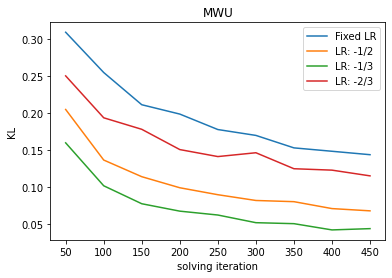

In [15]:
# MWU solver with different iterations
# evaluated by KL divergence of nash strategies by MWU and ECOS (as oracle)
import matplotlib.pyplot as plt

adaptive_lr_rates = [False, -1/2, -1/3, -2/3] # ref: Multiplicative weights update in zero-sum games
labels = ['Fixed LR', 'LR: -1/2', 'LR: -1/3', 'LR: -2/3']

for lr, label in zip(adaptive_lr_rates, labels):
    kl_list = []
    itr_list = []
    for i in range(1, 10):
        itr = i*50
        itr_list.append(itr)
        kl_list.append(compare_solvers(itr, lr))
    plt.plot(itr_list, kl_list, label=label)

plt.title('MWU')
plt.xlabel('solving iteration')
plt.ylabel('KL')
plt.legend()
plt.savefig('mwu_different_lr3.png')
